In [1]:
import pandas as pd
%load_ext rpy2.ipython
%R library(Hmisc)
%R library(mice)
%R library(ROCR)
%R library(boot)
%R library(rms)
%R library(ResourceSelection)
%R library(LogisticDx)
%R library(MissMech)
%R library(VIM)

/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Hmisc’


  warnings.warn(x, RRuntimeWarning)
/Users/andres/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘pack

array(['VIM', 'data.table', 'grid', 'colorspace', 'MissMech', 'LogisticDx',
       'ResourceSelection', 'rms', 'SparseM', 'boot', 'ROCR', 'gplots',
       'mice', 'Hmisc', 'ggplot2', 'Formula', 'survival', 'lattice',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S17')

## Load data and define inital sets of variables

In [3]:
src_data_file = '../data/2011-15/data.csv'

data = pd.read_csv(src_data_file, na_values='\\N')

mdead = len(data[data['OUT'] == 1])
msurv = len(data[data['OUT'] == 0])
print mdead
print msurv
print "Maximum DOF:", min(mdead, msurv) / 10.0

num_imp = 100

pd.set_option('display.max_rows', len(data.columns))
print data.describe().transpose()[['count', 'min', 'max']]
pd.reset_option('display.max_rows')

68
216
Maximum DOF: 6.8
            count          min          max
SN          291.0     1.000000   301.000000
AGE         289.0     3.000000    81.000000
SEX         289.0     0.000000     1.000000
OCCUP       291.0     0.000000    17.000000
RES         285.0     0.000000    53.000000
TRIBE       286.0     0.000000    31.000000
DOFBP       264.0     1.000000    35.000000
TEMP        280.0    34.320878    44.000000
SBP         277.0    70.000000   240.000000
DBP         277.0    30.000000   170.000000
PR          281.0    22.000000   140.000000
RR          280.0    18.000000   120.000000
TEMP_MAX    261.0    35.900000    43.300000
PR_MAX      263.0    24.000000   160.000000
SBP_MAX     260.0    12.000000   240.000000
DBP_MAX     260.0    50.000000   170.000000
RR_MAX      261.0    20.000000   100.000000
BLDING      291.0     0.000000     1.000000
SCNS        291.0     0.000000     1.000000
NSCNS       291.0     0.000000     1.000000
STHR        291.0     0.000000     1.000000
COUG    

In [26]:
# Included variables: P-value of marginal association with Outcome < 0.1

dem_vars = ['AGE'] 
sym_vars = ['SCNS', 'SWELL', 'JAUN', 'HEMA_bin', 'PROT_bin', 'BLDING', 'NSCNS', 'REYES', 'HEAD'] 
vit_vars = ['SBP_MAX', 'DBP_MAX', 'PR_MAX'] 
bmp_vars = ['BUN', 'K', 'CRE']
cbc_vars = ['WBC', 'PLT']
lft_vars = ['AST', 'ALT', 'ALK', 'ALB']
lab_vars = bmp_vars + cbc_vars + lft_vars

all_vars = dem_vars + sym_vars + vit_vars + lab_vars
# all_vars = bmp_vars + cbc_vars + lft_vars
# all_vars = bmp_vars + cbc_vars + lft_vars

all_formula = '~' + '+'.join(all_vars) 
sym_formula = '~' + '+'.join(sym_vars) 
vit_formula = '~' + '+'.join(vit_vars) 
lab_formula = '~' + '+'.join(lab_vars) 

print all_formula
print sym_formula
print vit_formula
print lab_formula

~AGE+SCNS+SWELL+JAUN+HEMA_bin+PROT_bin+BLDING+NSCNS+REYES+HEAD+SBP_MAX+DBP_MAX+PR_MAX+BUN+K+CRE+WBC+PLT+AST+ALT+ALK+ALB
~SCNS+SWELL+JAUN+HEMA_bin+PROT_bin+BLDING+NSCNS+REYES+HEAD
~SBP_MAX+DBP_MAX+PR_MAX
~BUN+K+CRE+WBC+PLT+AST+ALT+ALK+ALB


## Redundancy analysis for each group (signs/symptoms, vitals, labs)

In [28]:
%%R -i sym_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(sym_formula)
redun(formula, r2=0.3,type='adjusted',data=src_data)


Redundancy Analysis

redun(formula = formula, data = src_data, r2 = 0.3, type = "adjusted")

n: 128 	p: 9 	nk: 3 

Number of NAs:	 163 
Frequencies of Missing Values Due to Each Variable
    SCNS    SWELL     JAUN HEMA_bin PROT_bin   BLDING    NSCNS    REYES 
       0        0        0      155      152        0        0        0 
    HEAD 
       0 


Transformation of target variables forced to be linear

R-squared cutoff: 0.3 	Type: adjusted 

R^2 with which each variable can be predicted from all other variables:

    SCNS    SWELL     JAUN HEMA_bin PROT_bin   BLDING    NSCNS    REYES 
   0.004    0.000    0.000    0.061    0.069    0.000    0.014    0.013 
    HEAD 
   0.000 

No redundant variables



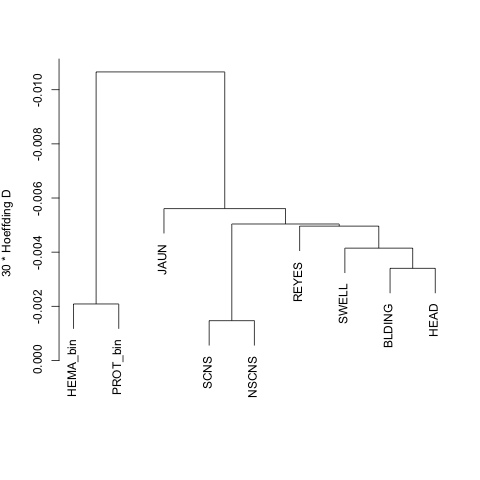

In [52]:
%%R -i sym_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(sym_formula)
vc <- varclus(formula, sim='hoeffding', data=src_data)
plot(vc)

In [29]:
%%R -i vit_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(vit_formula)
redun(formula, r2=0.3,type='adjusted',data=src_data)


Redundancy Analysis

redun(formula = formula, data = src_data, r2 = 0.3, type = "adjusted")

n: 260 	p: 3 	nk: 3 

Number of NAs:	 31 
Frequencies of Missing Values Due to Each Variable
SBP_MAX DBP_MAX  PR_MAX 
     31      31      28 


Transformation of target variables forced to be linear

R-squared cutoff: 0.3 	Type: adjusted 

R^2 with which each variable can be predicted from all other variables:

SBP_MAX DBP_MAX  PR_MAX 
  0.292   0.368   0.013 

Rendundant variables:

DBP_MAX

Predicted from variables:

SBP_MAX PR_MAX 

  Variable Deleted   R^2 R^2 after later deletions
1          DBP_MAX 0.368                          


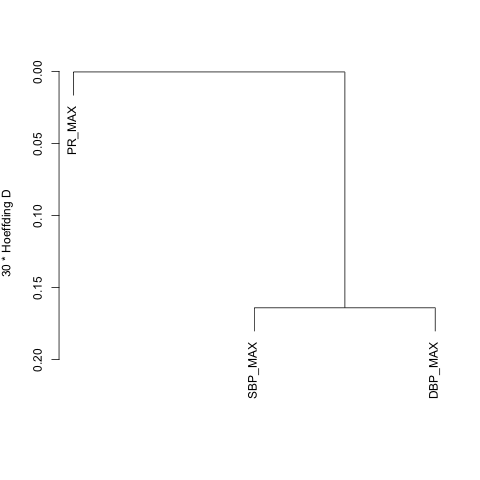

In [51]:
%%R -i vit_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(vit_formula)
vc <- varclus(formula, sim='hoeffding', data=src_data)
plot(vc)

In [30]:
%%R -i lab_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(lab_formula)
redun(formula, r2=0.3,type='adjusted',data=src_data)


Redundancy Analysis

redun(formula = formula, data = src_data, r2 = 0.3, type = "adjusted")

n: 14 	p: 9 	nk: 3 

Number of NAs:	 277 
Frequencies of Missing Values Due to Each Variable
BUN   K CRE WBC PLT AST ALT ALK ALB 
 90 100 154 101 141 194 184 223 210 


Transformation of target variables forced to be linear

R-squared cutoff: 0.3 	Type: adjusted 

R^2 with which each variable can be predicted from all other variables:

BUN   K CRE WBC PLT AST ALT ALK ALB 
  1   1   1   1   1   1   1   1   1 

Rendundant variables:

BUN PLT ALB

Predicted from variables:

K CRE WBC AST ALT ALK 

  Variable Deleted   R^2 R^2 after later deletions
1              BUN 1.000                   1 0.983
2              PLT 1.000                      0.58
3              ALB 0.592                          


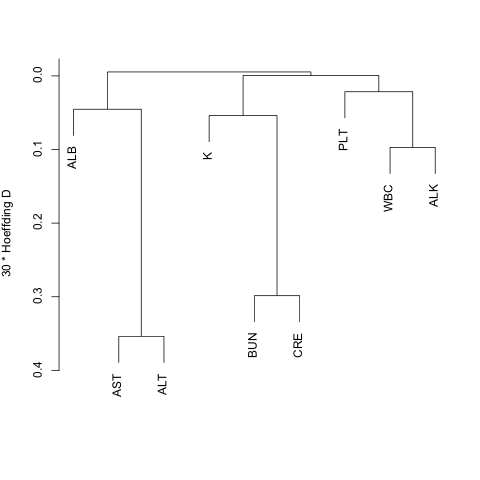

In [50]:
%%R -i lab_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(lab_formula)
vc <- varclus(formula, sim='hoeffding', data=src_data)
plot(vc)

## Redundancy analysis of all remining variables combined

In [68]:
# Removed all redundant variables or those inside a cluster with Hoeffding distance > 0.3 from 
# the group by group analysis (signs/symptoms, vitals, labs)
model0_vars = dem_vars + sym_vars + ['SBP_MAX', 'PR_MAX', 'K', 'CRE', 'WBC', 'AST', 'ALK'] 

model0_formula = '~' + '+'.join(model0_vars)
model0_imp_formula = '~' + '+'.join(['OUT'] + model0_vars)
model0_pred_formula = 'OUT~' + '+'.join(model0_vars)

In [69]:
%%R -i model0_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(model0_formula)
redun(formula, r2=0.3,type='adjusted',data=src_data)


Redundancy Analysis

redun(formula = formula, data = src_data, r2 = 0.3, type = "adjusted")

n: 28 	p: 17 	nk: 3 

Number of NAs:	 263 
Frequencies of Missing Values Due to Each Variable
     AGE     SCNS    SWELL     JAUN HEMA_bin PROT_bin   BLDING    NSCNS 
       2        0        0        0      155      152        0        0 
   REYES     HEAD  SBP_MAX   PR_MAX        K      CRE      WBC      AST 
       0        0       31       28      100      154      101      194 
     ALK 
     223 


Transformation of target variables forced to be linear

R-squared cutoff: 0.3 	Type: adjusted 

R^2 with which each variable can be predicted from all other variables:

     AGE     SCNS    SWELL     JAUN HEMA_bin PROT_bin   BLDING    NSCNS 
   0.189    0.000    0.000    0.000    0.559    0.000    0.000    0.002 
   REYES     HEAD  SBP_MAX   PR_MAX        K      CRE      WBC      AST 
   0.000    0.000    0.000    0.000    0.000    0.000    0.630    0.000 
     ALK 
   0.302 

Rendundant varia

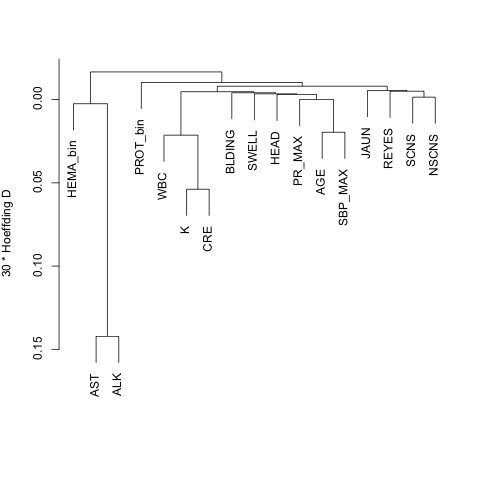

In [70]:
%%R -i model0_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")
formula <- as.formula(model0_formula)
vc <- varclus(formula, sim='hoeffding', data=src_data)
plot(vc)

## Saturated model

In [71]:
# Removed redundant/clustered variables (which are WBC and HEMA_bin)
satmod_vars = ['AGE', 
              'SCNS', 'SWELL', 'JAUN', 'PROT_bin', 'BLDING', 'REYES', 'HEAD', 
              'SBP_MAX', 'PR_MAX', 
              'K', 'CRE', 'AST', 'ALK']

satmod_formula = '~' + '+'.join(satmod_vars)
satmod_imp_formula = '~' + '+'.join(['OUT'] + satmod_vars)
satmod_pred_formula = 'OUT~' + '+'.join(satmod_vars)

~OUT + AGE + SCNS + SWELL + JAUN + PROT_bin + BLDING + REYES + 
    HEAD + SBP_MAX + PR_MAX + K + CRE + AST + ALK
Iteration 103 
OUT ~ AGE + SCNS + SWELL + JAUN + PROT_bin + BLDING + REYES + 
    HEAD + SBP_MAX + PR_MAX + K + CRE + AST + ALK

Variance Inflation Factors Due to Imputation:

Intercept       AGE      SCNS     SWELL      JAUN  PROT_bin    BLDING     REYES 
     1.68      1.21      1.27      1.51      1.37      2.08      1.22      1.87 
     HEAD   SBP_MAX    PR_MAX         K       CRE       AST       ALK 
     1.27      1.48      1.57      1.59      2.91      2.53      2.94 

Rate of Missing Information:

Intercept       AGE      SCNS     SWELL      JAUN  PROT_bin    BLDING     REYES 
     0.40      0.18      0.21      0.34      0.27      0.52      0.18      0.47 
     HEAD   SBP_MAX    PR_MAX         K       CRE       AST       ALK 
     0.21      0.33      0.36      0.37      0.66      0.60      0.66 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept  

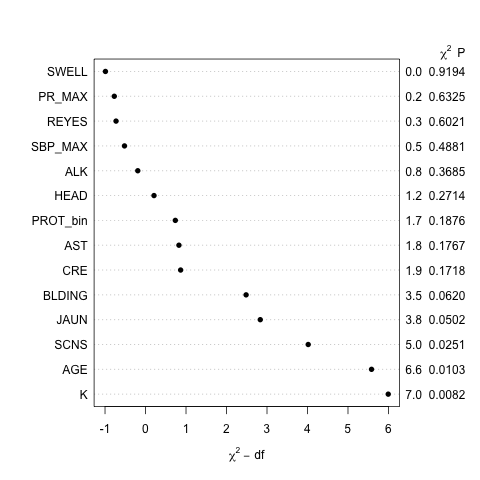

In [72]:
%%R -i num_imp,satmod_imp_formula,satmod_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(satmod_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(satmod_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)

## Parsimonious model

In [74]:
# Took top 7 variables from saturated model, ranked by P-value
parmod_vars = ['AGE', 'K', 'SCNS', 'JAUN', 'BLDING', 'CRE', 'AST']

parmod_formula = '~' + '+'.join(parmod_vars)
parmod_imp_formula = '~' + '+'.join(['OUT'] + parmod_vars)
parmod_pred_formula = 'OUT~' + '+'.join(parmod_vars)

~OUT + AGE + K + SCNS + JAUN + BLDING + CRE + AST
Iteration 103 
OUT ~ AGE + K + SCNS + JAUN + BLDING + CRE + AST

Variance Inflation Factors Due to Imputation:

Intercept       AGE         K      SCNS      JAUN    BLDING       CRE       AST 
     1.50      1.22      1.54      1.31      1.29      1.26      2.52      2.41 

Rate of Missing Information:

Intercept       AGE         K      SCNS      JAUN    BLDING       CRE       AST 
     0.33      0.18      0.35      0.24      0.22      0.21      0.60      0.59 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept       AGE         K      SCNS      JAUN    BLDING       CRE       AST 
   901.35   3086.19    811.22   1735.50   1968.55   2294.12    271.61    289.04 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 

Logistic Regression Model
 
 fit.mult.impute(formula = formula, fitter = lrm, xtrans = a, 
     data = src_data)
 
                        Model Likelihood     Dis

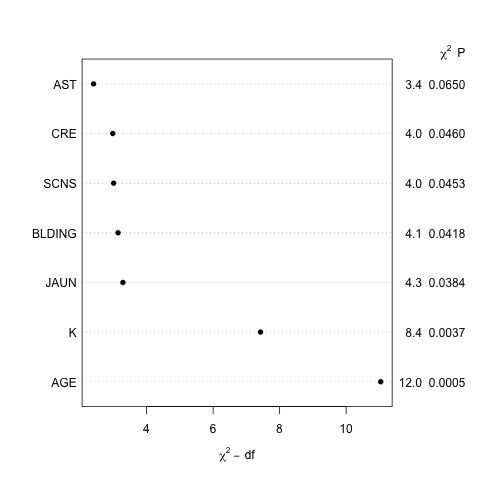

In [76]:
%%R -i num_imp,parmod_imp_formula,parmod_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(parmod_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(parmod_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)

## Clinical-only model

In [86]:
# Saturated clinical-only model using all sign/symptom vars (as there is no redundancy)
clinsat_vars = ['AGE'] + sym_vars

clinsat_formula = '~' + '+'.join(clinsat_vars)
clinsat_imp_formula = '~' + '+'.join(['OUT'] + clinsat_vars)
clinsat_pred_formula = 'OUT~' + '+'.join(clinsat_vars)

~OUT + AGE + SCNS + SWELL + JAUN + HEMA_bin + PROT_bin + BLDING + 
    NSCNS + REYES + HEAD
Iteration 103 
OUT ~ AGE + SCNS + SWELL + JAUN + HEMA_bin + PROT_bin + BLDING + 
    NSCNS + REYES + HEAD

Variance Inflation Factors Due to Imputation:

Intercept       AGE      SCNS     SWELL      JAUN  HEMA_bin  PROT_bin    BLDING 
     1.51      1.13      1.10      1.11      1.35      2.03      2.15      1.07 
    NSCNS     REYES      HEAD 
     1.10      1.08      1.08 

Rate of Missing Information:

Intercept       AGE      SCNS     SWELL      JAUN  HEMA_bin  PROT_bin    BLDING 
     0.34      0.12      0.09      0.10      0.26      0.51      0.53      0.07 
    NSCNS     REYES      HEAD 
     0.09      0.07      0.07 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept       AGE      SCNS     SWELL      JAUN  HEMA_bin  PROT_bin    BLDING 
   858.79   7016.73  10992.32  10064.58   1474.20    384.15    347.09  22951.10 
    NSCNS     REYES      HEAD 
 11354.00  18798.07  1

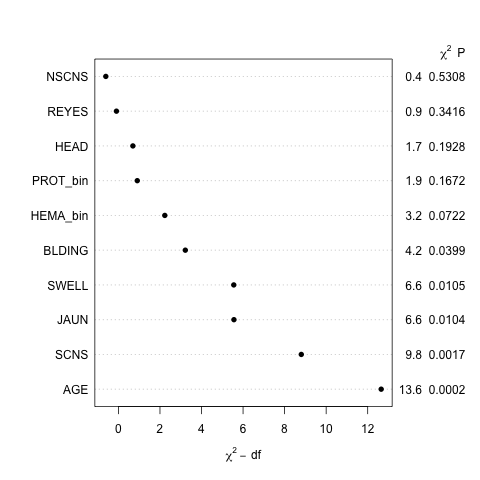

In [87]:
%%R -i num_imp,clinsat_imp_formula,clinsat_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(clinsat_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(clinsat_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)

In [99]:
# Parsimonious clinical-only model
clinpar_vars = ['AGE', 'SCNS', 'JAUN', 'SWELL', 'BLDING', 'HEMA_bin']

clinpar_formula = '~' + '+'.join(clinpar_vars)
clinpar_imp_formula = '~' + '+'.join(['OUT'] + clinpar_vars)
clinpar_pred_formula = 'OUT~' + '+'.join(clinpar_vars)

~OUT + AGE + SCNS + JAUN + SWELL + BLDING + HEMA_bin
Iteration 103 
OUT ~ AGE + SCNS + JAUN + SWELL + BLDING + HEMA_bin

Variance Inflation Factors Due to Imputation:

Intercept       AGE      SCNS      JAUN     SWELL    BLDING  HEMA_bin 
     1.44      1.08      1.09      1.20      1.04      1.05      2.35 

Rate of Missing Information:

Intercept       AGE      SCNS      JAUN     SWELL    BLDING  HEMA_bin 
     0.31      0.07      0.08      0.17      0.04      0.04      0.57 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept       AGE      SCNS      JAUN     SWELL    BLDING  HEMA_bin 
  1062.32  19171.33  14283.60   3561.35  57089.95  50041.65    299.66 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 

Logistic Regression Model
 
 fit.mult.impute(formula = formula, fitter = lrm, xtrans = a, 
     data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                      

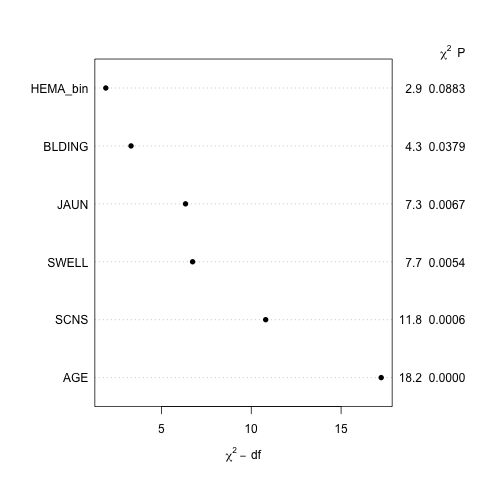

In [102]:
%%R -i num_imp,clinpar_imp_formula,clinpar_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(clinpar_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(clinpar_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)

## Lab-only model

In [105]:
# Saturated lab-only model using non-redundant vars
labsat_vars = ['AGE', 'K', 'CRE', 'WBC', 'AST', 'ALT', 'ALK']

labsat_formula = '~' + '+'.join(labsat_vars)
labsat_imp_formula = '~' + '+'.join(['OUT'] + labsat_vars)
labsat_pred_formula = 'OUT~' + '+'.join(labsat_vars)

~OUT + AGE + K + CRE + WBC + AST + ALT + ALK
Iteration 103 
OUT ~ AGE + K + CRE + WBC + AST + ALT + ALK

Variance Inflation Factors Due to Imputation:

Intercept       AGE         K       CRE       WBC       AST       ALT       ALK 
     1.87      1.51      1.77      2.72      1.65      5.72      7.30      2.94 

Rate of Missing Information:

Intercept       AGE         K       CRE       WBC       AST       ALT       ALK 
     0.47      0.34      0.44      0.63      0.40      0.83      0.86      0.66 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept       AGE         K       CRE       WBC       AST       ALT       ALK 
   456.82    870.59    520.57    247.15    633.03    145.40    132.95    226.97 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 

Logistic Regression Model
 
 fit.mult.impute(formula = formula, fitter = lrm, xtrans = a, 
     data = src_data)
 
                       Model Likelihood     Discrimination

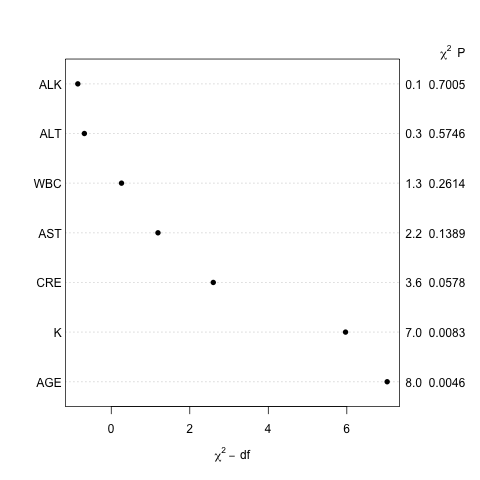

In [106]:
%%R -i num_imp,labsat_imp_formula,labsat_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(labsat_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(labsat_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)

In [107]:
# Parsimonious lab-only model
labpar_vars = ['AGE', 'K', 'CRE', 'AST']

labpar_formula = '~' + '+'.join(labpar_vars)
labpar_imp_formula = '~' + '+'.join(['OUT'] + labpar_vars)
labpar_pred_formula = 'OUT~' + '+'.join(labpar_vars)

~OUT + AGE + K + CRE + AST
Iteration 103 
OUT ~ AGE + K + CRE + AST

Variance Inflation Factors Due to Imputation:

Intercept       AGE         K       CRE       AST 
     1.63      1.37      1.66      3.07      2.99 

Rate of Missing Information:

Intercept       AGE         K       CRE       AST 
     0.39      0.27      0.40      0.67      0.67 

d.f. for t-distribution for Tests of Single Coefficients:

Intercept       AGE         K       CRE       AST 
   662.99   1363.82    625.81    217.75    223.38 

The following fit components were averaged over the 100 model fits:

  stats linear.predictors 

Logistic Regression Model
 
 fit.mult.impute(formula = formula, fitter = lrm, xtrans = a, 
     data = src_data)
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs           291    LR chi2     101.57    R2       0.439    C       0.870    
  0            223    d.f.        

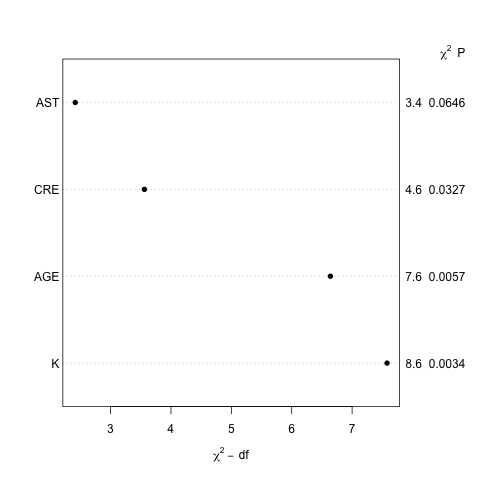

In [108]:
%%R -i num_imp,labpar_imp_formula,labpar_pred_formula,src_data_file

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

formula <- as.formula(labpar_imp_formula)
print(formula)
a <- aregImpute(formula, data=src_data, n.impute=num_imp)

formula <- as.formula(labpar_pred_formula)
print(formula)
f <- fit.mult.impute(formula, lrm, a, data=src_data)

print(f)
an <- anova(f)
print(an)
plot(an)